In [1]:
from face_alignment import FaceAlignment, LandmarksType

from loreal_poc.datasets.dataset_300W import Dataset300W
from loreal_poc.visualisation.draw import draw_marks
from loreal_poc.models.face_alignment import FaceAlignmentModel
import numpy as np

Benchmark

In [2]:
ds = Dataset300W(dir_path="300W/sample")

L'Oreal

In [3]:
from loreal_poc.datasets.base import FacialParts
chosen_idx = 4
image = ds.all_images[chosen_idx]
facial_part = FacialParts.right_half
picked_landmarks = ds.all_marks_for(facial_part)[chosen_idx]

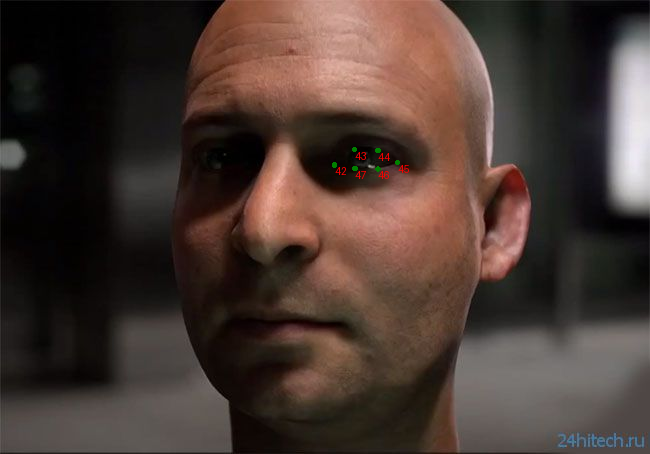

In [4]:
draw_marks(image, [picked_landmarks], ["green"], [True])

## Cropped image based on selected facial part

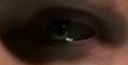

In [5]:

from loreal_poc.transformation_functions.transformation_functions import crop_based_on_facial_part
cropped_ds = crop_based_on_facial_part(ds, facial_part, rel_margin=0.05)
cropped_image = cropped_ds.all_images[chosen_idx]
cropped_image

## Model predictions on cropped image

In [6]:
model = FaceAlignmentModel(model=FaceAlignment(LandmarksType.TWO_D, device="cpu", flip_input=False))

/Users/rak/Documents/loreal-poc/.venv/lib/python3.11/site-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


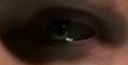

In [7]:
predictions = model.predict(cropped_ds, [chosen_idx]).prediction
draw_marks(cropped_image, [predictions[0]], ["red"], [True])

## Relevant model predictions on cropped image

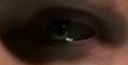

In [8]:
predictions = model.predict(cropped_ds, [chosen_idx], facial_part=facial_part).prediction
draw_marks(cropped_image, [predictions[0]], ["red"], [True])

## NME test on all cropped images

### rel_margin = `0.01`

In [9]:
from loreal_poc.tests.performance import test_nme_mean

result = test_nme_mean(model, ds, threshold=1,   
        transformation_function=crop_based_on_facial_part,
        transformation_function_kwargs={"facial_part": facial_part, "rel_margin": 0.01})

result

/Users/rak/Documents/loreal-poc/loreal_poc/tests/performance.py:54: RuntimeWarning: Mean of empty slice
  mes = np.nanmean(es, axis=1)
/Users/rak/Documents/loreal-poc/loreal_poc/tests/performance.py:125: RuntimeWarning: Mean of empty slice
  metric = np.nanmean(_calculate_nmes(prediction_result.prediction, marks))


Test failed
               Metric: nan (threshold = 1)
               Prediction fail rate: [1.0]

In [10]:
np.count_nonzero(np.isnan(result.prediction_results[0].prediction)), 68*2*5

(680, 680)

### rel_margin = `0.05`

In [11]:
test_nme_mean(model, ds, threshold=1,
         transformation_function=crop_based_on_facial_part,
         transformation_function_kwargs={"facial_part": facial_part, "rel_margin": 0.05})

/Users/rak/Documents/loreal-poc/.venv/lib/python3.11/site-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
/Users/rak/Documents/loreal-poc/loreal_poc/tests/performance.py:54: RuntimeWarning: Mean of empty slice
  mes = np.nanmean(es, axis=1)


Test failed
               Metric: 4.1807 (threshold = 1)
               Prediction fail rate: [0.8]

## NME test on original dataset

In [12]:
test_nme_mean(model, ds, threshold=1)

Test succeeded
               Metric: 0.0632 (threshold = 1)
               Prediction fail rate: [0.0]

## NME diff (between sliced and original dataset)

In [13]:
from loreal_poc.tests.performance import test_nme_mean_diff
test_nme_mean_diff(model, ds, threshold=1,
         transformation_function=crop_based_on_facial_part,
         transformation_function_kwargs={"facial_part": facial_part, "rel_margin": 0.01})

/Users/rak/Documents/loreal-poc/loreal_poc/tests/performance.py:125: RuntimeWarning: Mean of empty slice
  metric = np.nanmean(_calculate_nmes(prediction_result.prediction, marks))


AttributeError: 'TestResult' object has no attribute 'prediction_fail_rate'

In [ ]:
from loreal_poc.tests.performance import test_nme_std_diff
test_nme_std_diff(model, ds, threshold=1,
         transformation_function=crop_based_on_facial_part,
         transformation_function_kwargs={"facial_part": facial_part, "rel_margin": 0.01})

Test failed
               Metric: 101.1599 (threshold = 1)
               Prediction fail rate: 0.0